# Tutorial 1 - A first example

The aim of this tutorial is to show how this package can be used to solve a simple, but non-trivial, linear inverse problem. The methods are not fully explained, with later tutorials gradually building up the various ideas. 

The problem is as follows. We consider a function, $u$, defined on the unit circle, $\mathbb{S}^{1}$. We are given $n$ data of the form
$$
v_{i} = u(\theta_{i}) + z_{i}, 
$$
where the $\theta_{i}$ are known points and the $z_{i}$ are normally distributed random errors. From this data, we wish to estimate the unknown function, $u$, as best as possible. 

To proceed, we shall suppose that $u$ is an element of the Sobolev space, $H^{s}(\mathbb{S}^{1})$, with order $s>1/2$. It can be shown that on this space the the inverse problem is well-defined and that it can be solved using a range of methods that admit convergent numerical discretisations. 

First, we set up the model space, the forward operator, and a data error measure. With these terms defined, we can then define our forward problem. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygeoinf as inf
from pygeoinf.homogeneous_space.circle import Sobolev


# Set up the model space.
model_space = Sobolev.from_sobolev_parameters(2, 0.05)

# Set the sample points randomly.
n = 20
observation_points = model_space.random_points(n)

# Set the forward operator using a method of the Sobolev class.
forward_operator = model_space.point_evaluation_operator(observation_points)
data_space = forward_operator.codomain

# Set the data error measure. If standard deviation is zero, the data is  
# free of observational errors. 
standard_deviation = 0.1
data_error_measure = inf.GaussianMeasure.from_standard_deviation(
    data_space, standard_deviation) if standard_deviation > 0 else None

# Set up the forward problem
forward_problem = inf.LinearForwardProblem(forward_operator, data_error_measure)

With the forward problem set up, we can now generate synthetic data for a given model. To do this, we introduce a Gaussian measure on the model space from which a sample can be drawn. This prior measure will later be used within a Bayesian inversion, but for the moment it is just a convenient way to generate data. 

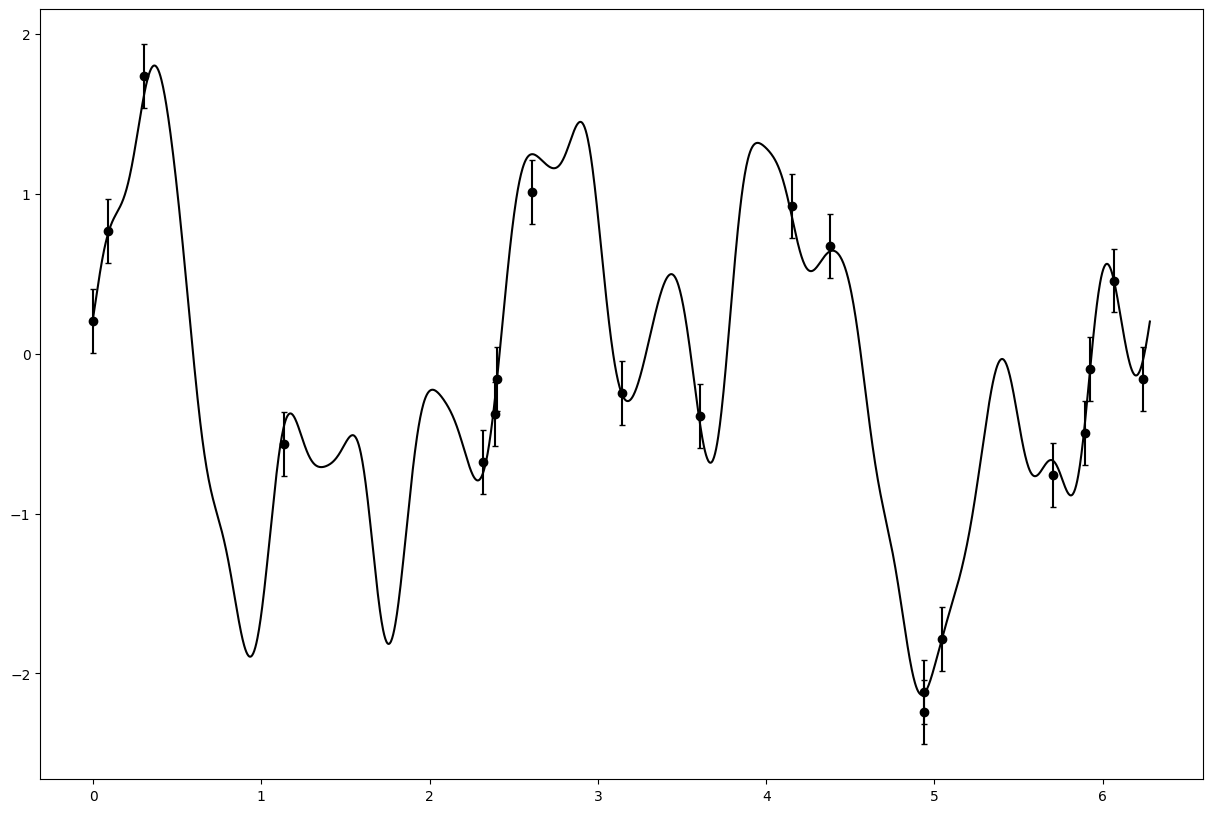

In [2]:
# Define a prior measure on the model space.
model_prior_measure = model_space.heat_gaussian_measure(0.1, 1)

# Sample a model and corresponding data.
model, data = forward_problem.synthetic_model_and_data(model_prior_measure)

# Plot the function along with the corresponding data.
fig, ax = model_space.plot(model, color="k", figsize=(15, 10))
ax.errorbar(observation_points, data, 2 * standard_deviation, fmt="ko", capsize=2)
plt.show()

In our first approach to solving the inverse problem, we obtain the **minimum norm solution**. Of all the models that fit the data acceptably, this is the unique element with the smallest norm. This method yields a single prefered model and does not readily provide for a quantification of uncertainty. Note that it is possible for this method to fail. This occurs when there is no element of the model space that fits the data statistically. This occurrence should be rare, but it is possible within this randomised example. 

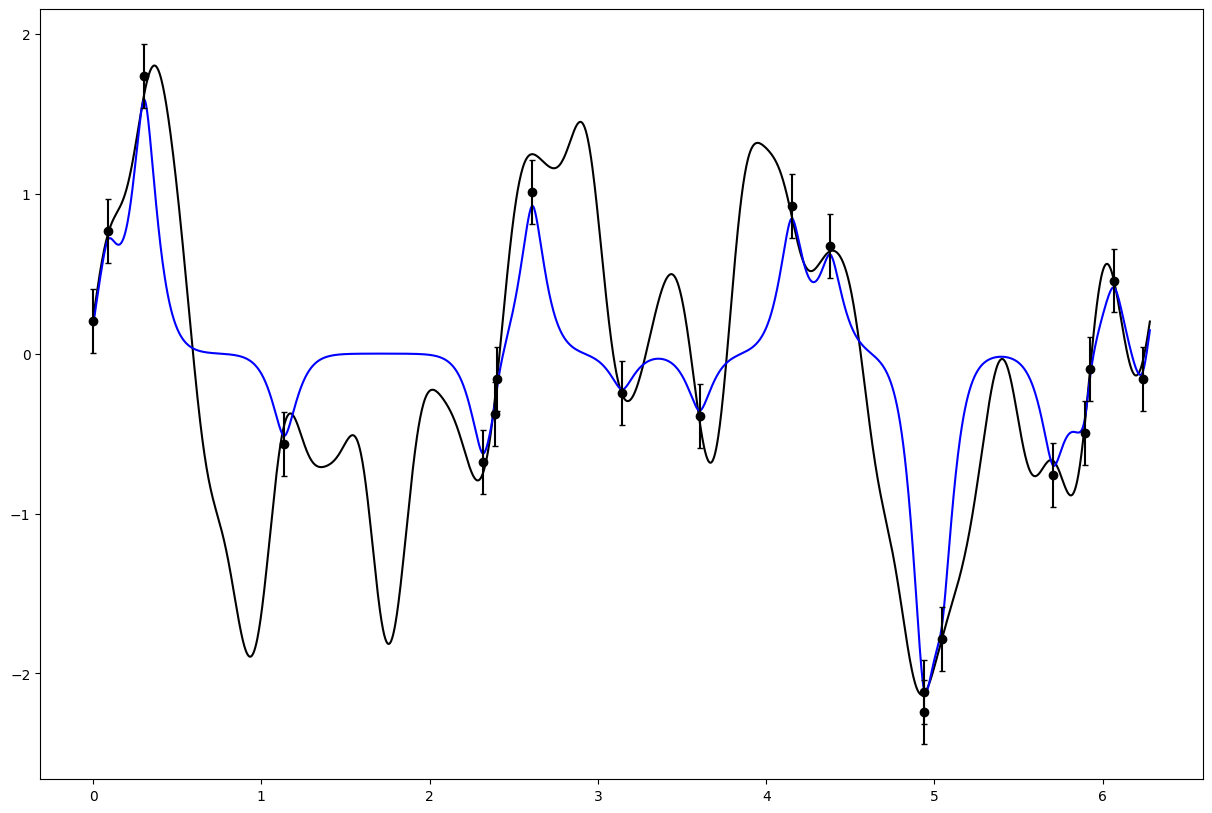

In [3]:
# Set up the inversion method. 
minimum_norm_inversion = inf.LinearMinimumNormInversion(forward_problem)

# Get the operator that maps the data to the minimum norm solution. 
minimum_norm_operator = minimum_norm_inversion.minimum_norm_operator(inf.CGSolver(rtol=1e-8))

# Compute and plot the minimum norm solution
minimum_norm_model = minimum_norm_operator(data)

fig, ax = model_space.plot(model, color='k', figsize=(15,10))
model_space.plot(minimum_norm_model, fig=fig, ax=ax,  color='b')
ax.errorbar(observation_points, data, 2 * standard_deviation, fmt="ko", capsize=2)
plt.show()

For the second method, we perform a Bayesian inversion. This requires a prior measure to be defined on the model space, and for simplicity we use the one introduced earlier and from which our data has been generated. This method yields a posterior measure on the model space that is also Gaussian. The posterior expectation is computed directly, but the posterior covariance is returned as a lazyily-evaluated linear operator. This means that its action on any model vector can be computed on demand, but its matrix representation has not been determined and stored. To obtain an estimate of the model uncertainty, we form a low-rank approximation to the posterior covariance and sample from this to estimate point-wise standard deviations.

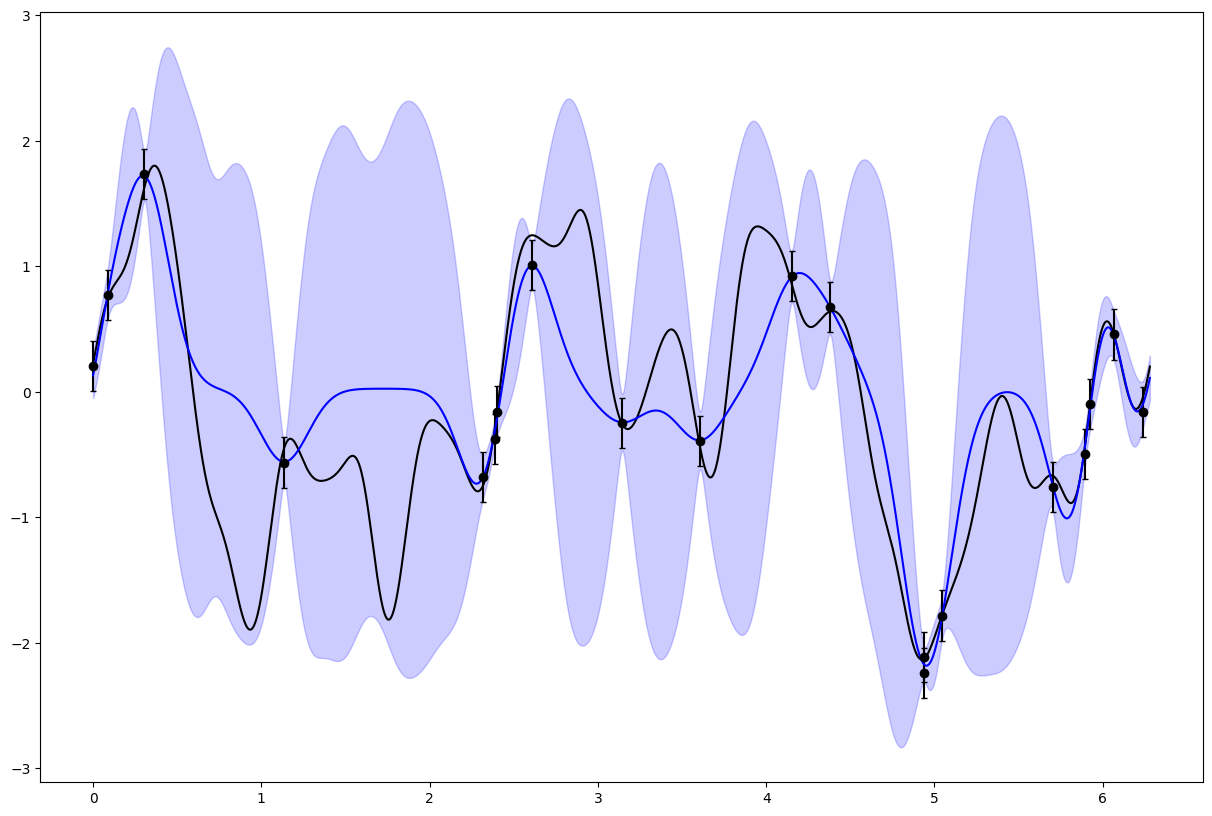

In [4]:
# Set up the inversion method.
bayesian_inversion = inf.LinearBayesianInversion(forward_problem, model_prior_measure)

# Get the posterior distribiution.
model_posterior_measure = bayesian_inversion.model_posterior_measure(
    data, inf.CholeskySolver()
)

# Estimate the pointwise variance
low_rank_posterior_approximation = model_posterior_measure.low_rank_approximation(
    10, method="variable", rtol=1e-4
)
model_pointwise_variance = low_rank_posterior_approximation.sample_pointwise_variance(100)
model_pointwise_std = np.sqrt(model_pointwise_variance)


# Plot the
fig, ax = model_space.plot(model, color="k", figsize=(15,10))
ax.errorbar(observation_points, data, 2 * standard_deviation, fmt="ko", capsize=2)
model_space.plot(
    model_posterior_measure.expectation, fig=fig, ax=ax, color="b"
)
model_space.plot_error_bounds(
    model_posterior_measure.expectation,
    2 * model_pointwise_std,
    fig=fig,
    ax=ax,
    alpha=0.2,
    color="b",
)
plt.show()